# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [90]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import random

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [110]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [111]:
M_train = data_train
M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k], ddof=0)
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set

print(sigma)

[ 1.23328245  0.47303067  7.44601122  1.45269103  0.41684299  1.39024269
  0.70355366 29.08227243]


In [6]:
"""
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T
"""

'\n# Alternative WITHOUT FOR\nnormalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function \nM_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST\nmoy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )\nsigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )\n\nM_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T\n'

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

In [7]:
# On charge les données dans un datframe + renommer les colonnes pour une meilleur visibilité 
df = pd.DataFrame(M_train[:,:-1])
df = df.rename(columns={0:'lcavol', 1:'lweight', 2:'age', 3:'lbph', 4:'svi', 5:'lcp', 6:'gleason', 7:'pgg45', 8:'lpsa'})
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-1.535180,-1.810979,-1.980425,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,-0.430783
1,-1.871221,-0.647911,-0.906025,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,-0.162519
2,-1.479237,-1.976330,1.242777,-1.003472,-0.537086,-0.843084,0.381857,-0.215549,-0.162519
3,-2.041272,-0.725785,-0.906025,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,-0.162519
4,-0.455756,-0.409561,-0.368824,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253,0.371564


In [8]:
# On affiche la covariance en prenant la transposé 
# car np.cov calcule la matrice de covariance basée sur les lignes et non les colonnes
cov = np.round(pd.DataFrame(np.cov(df.transpose())),3).rename(columns={0:'lcavol', 1:'lweight', 2:'age', 3:'lbph', 4:'svi', 5:'lcp', 6:'gleason', 7:'pgg45', 8:'lpsa'})
cov

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,1.015,0.305,0.291,0.064,0.602,0.703,0.433,0.490,0.892
1,0.305,1.015,0.322,0.444,0.184,0.159,0.024,0.075,0.590
2,0.291,0.322,1.015,0.292,0.131,0.176,0.371,0.280,0.277
3,0.064,0.444,0.292,1.015,-0.141,-0.090,0.033,-0.031,0.320
4,0.602,0.184,0.131,-0.141,1.015,0.681,0.312,0.489,0.678
5,0.703,0.159,0.176,-0.090,0.681,1.015,0.484,0.673,0.595
6,0.433,0.024,0.371,0.033,0.312,0.484,1.015,0.769,0.417
7,0.490,0.075,0.280,-0.031,0.489,0.673,0.769,1.015,0.545
8,0.892,0.590,0.277,0.320,0.678,0.595,0.417,0.545,1.459


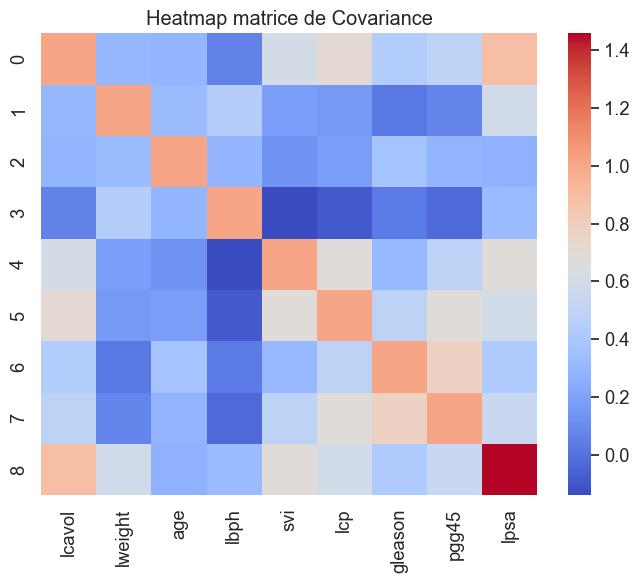

In [9]:
# Affichage sous forme d'une heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(cov, cmap='coolwarm', fmt='.2f', xticklabels=True, yticklabels=True)
plt.title('Heatmap matrice de Covariance')
plt.show()

## Observations
On observe déja que la matrice de covariance est bien symétrique. On retrouve les valeurs de variances et covariances des différentes features de notre matrice.
On observe une variance de la target Lpsas plus forte (1,46) que la variance des autres colonnes qui est égale à 1,015 pour toute.
On observe une covariance importante entre la target lpsas et les colonnes lcavol et svi

Quelques rappels à propos de la notion de covariance : https://fr.wikipedia.org/wiki/Covariance

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [10]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

In [11]:
# Exercise 1
#Building the matrix for the training set
t_train = data_train[:,8]
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train,1)), M_train[:, 0:8]), axis=1)
print(X_train.shape)

(67, 9)


In [12]:
#compute the Moore-Penrose pseudo inverse

X_dag = la.inv(X_train.T @ X_train) @ X_train.T
print(f"Xdag shape: {X_dag.shape}")

#Compute beta_hat the regresion vector
beta_hat = (X_dag @ t_train).reshape(-1, 1)
print(f"beta_hat shape: {beta_hat.shape}")

# Prediction on the test set
t_hat = X_test @ beta_hat

Xdag shape: (9, 67)
beta_hat shape: (9, 1)


In [13]:
#Compute MSE
epsilon =  (t_hat - t_test)**2
MSE =  np.sum(epsilon)/ t_hat.shape[0]
print(f"MSE = {MSE}")

MSE = 47.17329449881957


In [14]:
#biais
print(f"biais = {beta_hat [0][0]}") 

biais = 2.4523450850746267


beta_hat [0] corresponds to the biais

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [15]:
# Exercise 2
#Define the variable number
p = X_train.shape[1] - 1
print(f"p: {p}\n")

#Extract the diagonal of a matrix
vXX = np.diag(la.inv(X_train.T@ X_train))
print(f"vj shape: {vXX.shape}\n")

# Compute an estimate of the variance sigma
t_train_hat = X_train @ beta_hat
sigma_hat = sum((t_train - t_train_hat.squeeze())**2)/(X_train.shape[0]-p-1)
print(f"Sigma hat: {sigma_hat}\n")

# Compute Z_scores
Z = [np.round(beta_hat[j][0]/(sigma_hat*np.sqrt(vXX[j])),3) for j in range (len(beta_hat))]
print(f"Z  = {Z}")

# Select the most significant entries with a 95% interval
selected_features = np.abs(Z) > 2
columns = np.array(['biais'] + df.columns.to_list()[:-1])
print(columns)
print(f"Selected entries: {columns[selected_features]}")
# The following features are considered non significant
print(f"Entries where the null hypothesis wasn't rejected: {columns[ np.abs(Z) < 2]}")

p: 8

vj shape: (9,)

Sigma hat: 0.5073514562053173

Z  = [39.565, 7.534, 3.862, -1.96, 2.886, 3.467, -2.621, -0.206, 2.44]
['biais' 'lcavol' 'lweight' 'age' 'lbph' 'svi' 'lcp' 'gleason' 'pgg45']
Selected entries: ['biais' 'lcavol' 'lweight' 'lbph' 'svi' 'lcp' 'pgg45']
Entries where the null hypothesis wasn't rejected: ['age' 'gleason']


In [16]:
beta_hat_new = beta_hat
# We set to zero the values of regression coefficients that weren't conserved
beta_hat_new[ np.abs(Z) < 2] = 0
print(f"New values of beta hat: {beta_hat_new}\n")

# We compute an estimate of t_test with the new regression coefficients
t_hat_new = X_test @ beta_hat_new
# We compute the MSE
MSE_new =  np.sum((t_hat_new - t_test)**2)/ t_test.shape[0]
print(f"MSE: {MSE_new}")
# The MSE_new > MSE so the model performs worse than before 

New values of beta hat: [[ 2.45234509]
 [ 0.71104059]
 [ 0.29045029]
 [ 0.        ]
 [ 0.21041951]
 [ 0.30730025]
 [-0.28684075]
 [ 0.        ]
 [ 0.27526843]]

MSE: 50.03081886659442


In [20]:
# Compute the regression estimate and MSE using only the selected entries

#compute the Moore-Penrose pseudo inverse

X_dag = la.inv(X_train[:,selected_features].T @ X_train[:,selected_features]) @ X_train[:,selected_features].T
print(f"Xdag shape: {X_dag.shape}")

#Compute beta_hat the regresion vector
beta_hat_2 = (X_dag @ t_train).reshape(-1,1)
print(f"beta_hat shape: {beta_hat_2.shape}")

# Prediction on the test set
t_hat = X_test[:,selected_features] @ beta_hat_2

#Compute MSE
epsilon =  (t_hat - t_test)**2
MSE_2 =  np.sum(epsilon)/ t_hat.shape[0]
print(f"MSE = {MSE}")

# The MSE obtained by recomputing the regression vector estimate is identical to the one obtained previously 
# so we haven't improved the generalisation capability of our model but we've proved that the columns removed do not hold any influence on the prediction error

Xdag shape: (7, 67)
beta_hat shape: (7, 1)
MSE = 47.17329449881957


# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [72]:
t = data_train[:,8]   # column of targets
t0 = np.mean(t)

N_test = data_test.shape[0]
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  
# Here the 1st column of X_test is a column of ones.
#t_hat_reg = X_test.dot(beta_hat_reg)

In [22]:
# Exercise 3
#Building the matrix for the training set 
# We don't add the columns of one's as we do not want to penalise the bias
t_c = data_train[:,8] - t0
N_train = data_train.shape[0]
X_c =  M_train[:, 0:8]
print(X_train.shape)

(67, 9)


In [64]:
#Compute beta_hat the regresion vector
ld = 25
p = X_c.shape[1]
beta_hat_reg = (la.inv(ld*np.eye(p) +  X_c.T @ X_c) @ X_c.transpose() @ t_c).reshape(-1, 1)

# The biais is the mean of the training set target
beta_0 = t0
beta_hat_reg = np.concatenate((np.array(beta_0).reshape(1,1),beta_hat_reg))
print(f"beta_hat_reg shape: {beta_hat_reg.shape}\n")

# Prediction on the test set
t_hat = X_test @ beta_hat_reg

#Compute MSE
epsilon =  (t_hat - t_test)**2
MSE_reg =  np.sum(epsilon)/ t_hat.shape[0]
print(f"MSE_reg = {MSE_reg}\n")
print(f"MSE_2 = {MSE_2}\n")

# MSE_reg < MSE, using riddge regression we've managed to improve our MSE
# Let's take a look at the coefficients 
pd.merge(pd.DataFrame({'index': columns, 'beta_hat_reg': beta_hat_reg.squeeze()}),(pd.DataFrame(({'index': columns[selected_features], 'beta_hat_2': beta_hat_2.squeeze()}))),how='outer', on= 'index')

# We can observe that the biais stays the same as it's still t0. 
# Overall the coefficients of beta_hat_2 are bigger than the respective coefficients in beta_hat_reg, 
# which makes sense as ridge regression penalizes coefficients that are too high.


beta_hat_reg shape: (9, 1)

MSE_reg = 44.75465262184944

MSE_2 = 47.66532790460011



,index,beta_hat_reg,beta_hat_2
0,biais,2.452345,2.452345
1,lcavol,0.422109,0.678032
2,lweight,0.248792,0.266366
3,age,-0.042265,NaN
4,lbph,0.165754,0.183008
5,svi,0.230915,0.315281
6,lcp,0.010663,-0.265293
7,gleason,0.043060,NaN
8,pgg45,0.131513,0.219316


# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [107]:
lmax = 40
lambda_pos = arange(0,lmax+1) 

N_test = 10
m=np.zeros(8)
s = np.zeros(8)
X_traink = np.zeros((X_train.shape[0]-N_test,8))
X_testk = np.zeros((N_test,8))
erreur = np.zeros((6,lmax+1))
erreur_rel = np.zeros((6,lmax+1))

In [160]:
# Exercise 4 
random_seed = 10
shuffled_data_train = data_train.copy()
random.shuffle(shuffled_data_train)


for ld in lambda_pos:
    error_ld = np.zeros(6)
    erreur_rel_ld = np.zeros(6)
    for j in range(6):   # loop on test subsets
        # extraction of testset
        testset  = shuffled_data_train[arange(j*N_test,(j+1)*N_test),0:9] 
        # extraction of trainset
        trainset = shuffled_data_train[hstack((arange(j*N_test),arange((j+1)*N_test,data_train.shape[0]))),0:9] 
        
        # normalization of entries
        normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)   
        moy = np.array( [ np.mean(vec) for vec in trainset[:,0:8].T ] )
        sigma = np.array( [ np.std(vec, ddof=0) for vec in trainset[:,0:8].T ] )
        X_c = np.array( [ normalize(vec) for vec in trainset[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
        X_test = np.array([ (testset[:,k]-moy[k])/sigma[k] for k in range(X_c.shape[1]) ] ).T
        X_test  = np.hstack((np.ones((N_test,1)), X_test[:,0:8]))  

        # We normalise the training target
        t0 = np.mean(trainset[:,8])
        t_c = trainset[:,8] - t0
        t_test = testset[:,8]

        # We compute the regression vector for the specifique fold and lambda value
        p = X_c.shape[1]
        beta_hat_reg = (la.inv(ld*np.eye(p) +  X_c.T @ X_c) @ X_c.transpose() @ t_c).reshape(-1, 1)

        # The biais is the mean of the training set target
        beta_0 = t0
        beta_hat_reg = np.concatenate((np.array(beta_0).reshape(1,1),beta_hat_reg))
        # Prediction on the test set
        t_hat = X_test @ beta_hat_reg

        #Compute MSE
        epsilon =  (t_hat - t_test)**2
        ecart_rel = [abs(t_hat[k][0] - t_test[k])/t_test[k] for k in range (len(t_hat))]
        MSE_reg =  np.sum(epsilon)/ t_hat.shape[0]
        error_ld[j] = MSE_reg
        erreur_rel_ld[j] = np.mean(ecart_rel)

    erreur[:,ld] = error_ld
    erreur_rel[:,ld] = erreur_rel_ld
        

In [161]:
erreur.mean(axis=0)

array([14.67850887, 14.52618012, 14.39127   , 14.26987953, 14.15934295,
       14.0577545 , 13.96370193, 13.87610711, 13.79412623, 13.71708469,
       13.6444333 , 13.57571789, 13.51055775, 13.44862989, 13.38965739,
       13.33340062, 13.27965052, 13.22822329, 13.17895629, 13.13170472,
       13.08633894, 13.04274234, 13.00080951, 12.96044478, 12.92156098,
       12.8840784 , 12.84792391, 12.81303022, 12.77933523, 12.74678145,
       12.71531558, 12.68488803, 12.65545262, 12.6269662 , 12.59938841,
       12.57268143, 12.54680973, 12.52173993, 12.49744054, 12.47388191,
       12.45103601])

In [162]:
erreur_rel.mean(axis=0)

array([-0.0883559 , -0.11798818, -0.15089238, -0.18179922, -0.21096892,
       -0.23860726, -0.26488104, -0.28992816, -0.31386449, -0.33678868,
       -0.35870111, -0.37971343, -0.39993704, -0.41942938, -0.43788684,
       -0.45573079, -0.47300453, -0.48974284, -0.50597728, -0.52173655,
       -0.53704689, -0.55193232, -0.56628401, -0.58021733, -0.59379134,
       -0.6070232 , -0.61992884, -0.63252306, -0.64481966, -0.65683153,
       -0.66852392, -0.67982425, -0.69087619, -0.7016896 , -0.71227371,
       -0.72263725, -0.73278844, -0.74273504, -0.7524844 , -0.76204347,
       -0.77141884])

In [ ]:
# Exercise 4 ---------------
# ...
# averaged error on the 6 training/test sets ?
# averaged error on the 6 training/test sets ?
# standard variation of this error estimate ?

# print(erreur_lambda, std_erreur_lambda, erreur_rel_lambda)


In [ ]:
# Exercise 4 FIGURE ---------------
# ...


In [ ]:
# Exercise 4 (continued)